<a href="https://colab.research.google.com/github/GoliVyshnavi/project2/blob/master/CV_final_assignment_GAN_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS7GV1 FINAL ASSIGNMENT

In this assignment you will be asked to implement a [Generative Adversarial Network (GAN)](https://proceedings.neurips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf), more precisely a [Deep Convolutional Generative Adversarial Network (DCGAN)](https://arxiv.org/pdf/1511.06434.pdf), to generate images of clothes by training the networks on the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

Instructions and questions are presented directly in this notebook, please answer the questions in the notebook in the specified text boxes. When submitting your assignment, please submit in a single .zip file:
- This completed notebook
- The checkpoint file where your model and other variables are saved
- The tensorboard events file

Do not submit the dataset files.

In [2]:
# Please add your name and student number below.
studentName = "Vyshnavi Goli"
studentNumber = 21332580

# Step 1: Import the libraries (0.5 point)

You will need the same libraries as used in the labs.

In [43]:
# Import the libraries here
import torch
import os
import random
from torch import Tensor
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor,Lambda
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [24]:
# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on " + str(device))
if str(device)=='cpu':
  ngpu=0
else:
  ngpu=1

Running on cpu


In [7]:
# Mount your google drive here to make sure the saved data is not lost
mydrive = '/content/gdrive/'
from google.colab import drive
drive.mount(mydrive)
working_dir = mydrive + 'MyDrive/Final_assignment/'
# working_dir = './' # To save data locally, will get deleted when this runtime is recycled!
if not(os.path.isdir(working_dir)):
    os.makedirs(working_dir)

Mounted at /content/gdrive/


# Step 2: Load the dataset (1 point)

For this assignment, use the FashionMNIST dataset.

In [6]:
# Define the transforms to be applied to the training data. In order:
# - resize images to size 32x32
# - convert to tensor
# - normalize with mean 0.5 and standard deviation of 0.5
resize = transforms.Resize([32,32])
tensor_transform = ToTensor()
normalise_transform = transforms.Normalize(mean=0.5, std=0.5)

# Download the training dataset
training_data = datasets.FashionMNIST(root = 'data', train = True , download = True,transform=transforms.Compose([resize,tensor_transform,normalise_transform]))

# Create the dataloader with a batch size of 64 and 2 workers
train_dataloader = DataLoader(training_data,batch_size=64,num_workers=2)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



# Step 3: Visualize the data (1 point)

Display a 8x8 grid of training images.

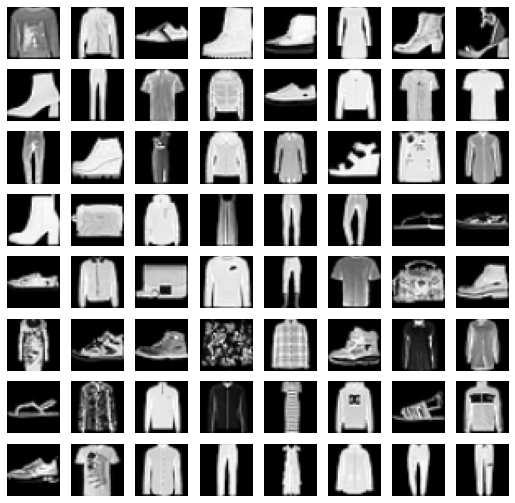

In [8]:
# Plot some training images in a 8x8 grid
#training_features, training_labels = next(iter(train_dataloader))
figure = plt.figure(figsize=(9, 9))
col, row = 8, 8
for j in range(1, col * row + 1):
    index = torch.randint(len(training_data), size=(1,)).item()
    image, label = training_data[index]
    figure.add_subplot(row, col, j)
    #figure.tight_layout(pad=0.1)
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
plt.show()


# Question 3: Comment about the input data (0.5 point)

Fashion datasets containing images of clothes, footwear and bags. each image is associated with a label,
28*28 size
grayscale



# Step 4: Define the networks

Define a Generator and a Discriminator network, and instantiate them by applying the ``weights_init`` function given below.
Use a latent vector z of size 100. 


In [9]:
# Custom weights initialization called on generator and discriminator, 
# which randomly initialize all weights to mean=0, stdev=0.02.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Step 4.1: Define the generator (3 points)

In [26]:
# Define the generator network with the following structure:
# Generator(
    # (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    # (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    # (2): ReLU(inplace=True)
    # (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    # (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    # (5): ReLU(inplace=True)
    # (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    # (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    # (8): ReLU(inplace=True)
    # (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    # (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    # (11): ReLU(inplace=True)
    # (12): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    # (13): Tanh()
# )

class Generator(nn.Module):
  def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.Tanh()
        )
  def forward(self, input):
     return self.main(input)
  
# Define the generator network netG, and instantiate using the weights_init function.
netG = Generator(ngpu).to(device)
netG.apply(weights_init)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

def __init__(self):
    super(Generator, self).__init__()
    self.Conv1 = nn.ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    self.BatchNorm1 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.relu1 = nn.ReLU(inplace=True)
    self.Conv2 = nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    self.BatchNorm2 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.relu2 = nn.ReLU(inplace=True)
    self.Conv3 = nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    self.BatchNorm3 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.relu3 = nn.ReLU(inplace=True)
    self.Conv4 = nn.ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    self.BatchNorm4 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    self.relu = nn.ReLU(inplace=True)
    self.Conv5 = nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.Tan1 = nn.Tanh()
   


# Question 4.1: What can you say about the structure of the generator network? (0.5 point)

*Write your answer here.*

# Step 4.2: Define the discriminator (3 points)

In [30]:
# Define the discriminator network with the following structure:
# Discriminator(
    # (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    # (1): LeakyReLU(negative_slope=0.2, inplace=True)
    # (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    # (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    # (4): LeakyReLU(negative_slope=0.2, inplace=True)
    # (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    # (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    # (7): LeakyReLU(negative_slope=0.2, inplace=True)
    # (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    # (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    # (10): LeakyReLU(negative_slope=0.2, inplace=True)
    # (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    # (12): Sigmoid()
# )

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
      nn.LeakyReLU(negative_slope=0.2, inplace=True),
      nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.2, inplace=True),
      nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.2, inplace=True),
      nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.LeakyReLU(negative_slope=0.2, inplace=True),
      nn.Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False),
      nn.Sigmoid()
        )
    def forward(self, input):
      return self.main(input)



# Define the generator network netG, and instantiate using the weights_init function.
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

# Question 4.2: What can you say about the structure of the discriminator network? (0.5 point)

*Write your answer here.*

# Step 5: Define the Loss Function and Optimizers (5 points)

Hint: look at existing papers and online tutorials to find which loss function, optimizer, and hyper parameters should be used to train a GAN.
Define an optimizer for each generator and discriminator network.

In [16]:
# Initialize the loss function
learning_rate = 1e-3
epochs = 5
loss_fn = nn.BCELoss()

# Setup optimizers for both netG and netD
optimizer_netG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_netD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))

In [38]:
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
nz=100
# Create batch of latent vectors that we will use to visualize
# the progression of the generator
random.seed(studentNumber) # Fix the random seed to be able to reproduce the results
torch.manual_seed(studentNumber)
fixed_noise = torch.randn(8*8, nz, 1, 1, device=device)
fixed_noise.shape

torch.Size([64, 100, 1, 1])

# Question 5: Explain here how the GAN losses works. (1 point)

*Write your answer here.*

# Step 6: Display the outputs of the generator and discriminator before training (1 point)

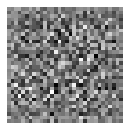

In [56]:
# Use the batch of 64 latent vectors created above as input to the generator 
# and visualize the output in a 8x8 grid
figure = plt.figure(figsize=(20, 20))
cols, rows = 8, 8
img = netG(fixed_noise)
images = img.detach().numpy()
for i,img in zip(range(1, cols * rows + 1),images[0]): 
   # figure = plt.figure(figsize=(8, 8))  
    figure.add_subplot(rows, cols, i)
    plt.imshow(img,cmap='gray')
    #figure.tight_layout()
    plt.axis("off")
    
plt.show()

# Use the 64 images just generated as input to the discriminator
# and print the output probabilities
# *Write your code here*

# Step 7: Train the network (10 points)

Training a GAN can take time. It is recommended that you save your model regularly so you can resume training later if needed, and use Tensor Board to monitor the progress of the training. If you choose the right parameters, you should observe shapes of clothes emerging before the end of the first epoch. Use at least 1 or 2 epochs, each epoch can take ~1h.


In [ ]:
# Create a SummaryWriter using tensorboard.
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(working_dir + 'runs/')

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# load tensorboard in this cell
# You will need to run this cell again or use the TensorBoard refresh to view new changes throughout the notebook.
%tensorboard --logdir=/content/gdrive/MyDrive/Final_assignment/runs

In [ ]:
# Training Loop
# Use at least 1 to 2 epochs.
# If you choose the right parameters, you should observe shapes of clothes emerging 
# before the end of the first epoch.
num_epochs = 5

# In addition to TensorBoard, use these lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

# Reload your saved models from previous training iterations here
# (see https://pytorch.org/tutorials/beginner/saving_loading_models.html)
checkpoint_path = working_dir + 'checkpoint'
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    netG.load_state_dict(checkpoint['netG_model'])
    netD.load_state_dict(checkpoint['netD_model'])
    optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
    optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
    errG = checkpoint['errG']
    errD_real = checkpoint['errD_real']
    errD_fake = checkpoint['errD_fake']
    iters = checkpoint['iters']
    start_epoch = checkpoint['epoch']
    img_list = checkpoint['img_list']
    G_losses = checkpoint['G_losses']
    D_losses = checkpoint['D_losses']

else:
  iters = 0
  start_epoch = 0


print("Starting Training Loop from epoch " + str(start_epoch))
for epoch in range(start_epoch, num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update the discriminator
        # *Write your code here*
        
        # Update the generator
        # *Write your code here*
        
        # Output training stats every 50 iterations (you can change this number if needed)
        if i % 50 == 0:
            # Print the current epoch, the current batch iteration, discriminator and generator losses,
            # the average probability output of the discriminator after the update 
            # of the discriminator trained with all-real batch, trained with all-fake batch,
            # abd after the update of the generator
            # *Write your code here*
        
            # Log the generator loss here (tensorboard + append to G_losses)
            # *Write your code here*
                        
            # Log the discriminator loss here (tensorboard + append to D_losses)
            # *Write your code here*
                    
            # Check how the generator is doing by visualizing G's output on fixed_noise
            # (tensorboard + append in img_list)
            # *Write your code here*
            
            # Save the checkpoint here, which can be used to resume training later.
            # (see https://pytorch.org/tutorials/beginner/saving_loading_models.html)
            torch.save({
              'epoch': epoch,
              'iters': iters,
              'netG_model': netG.state_dict(),
              'netD_model': netD.state_dict(),
              'optimizerG_state_dict': optimizerG.state_dict(),
              'optimizerD_state_dict': optimizerD.state_dict(),
              'errG': errG,
              'errD_real': errD_real,
              'errD_fake': errD_fake,
              'img_list': img_list,
              'G_losses': G_losses,
              'D_losses': D_losses
            }, checkpoint_path)
  
        iters += 1

# Save the models and stats after training
# *Write your code here*


# Question 7: Comment on the training process. (1 point)
Look at the generator and discriminator losses over iterations. Comment on the the discriminator output probability when fed real or fake images as input and the evolution of these probabilities over time.

*Write your answer here.*

# Step 8: Display results (1 point)

Load saved models and results.

In [ ]:
# Load the relevant models and stats from the checkpoint file
# *Write your code here*

Plot the generator and discriminator losses.

In [ ]:
 # *Write your code here*

Visualize generator progression

In [ ]:
# Animate images generated over epochs
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Compare real images and generated images

In [ ]:
# Load real images from the dataloader and plot them in a 8x8 grid
# *Write your code here*

# Generate and plot fake images in a 8x8 grid side by side with the real images 
# *Write your code here*

# Question 8: Comment on your results. (1 point)

*Write your answer here.*